# Ajuste de modelos via cuadrados mínimos usando PyTorch

## Ejercicio 1)

Instale `pytorch` usando el comando de bash

In [1]:
!pip3 install torch torchvision torchaudio torchviz

Defaulting to user installation because normal site-packages is not writeable


## Ejercicio 2)

**1)** Importe librerias `numpy`, `scipy` y `matplotlib`.

**2)** Importe librerias de `pytorch`.
Para ello, vea el colab `pytorch-tutorial-1-tensores.ipynb`.

In [2]:
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchviz import make_dot
import torch.optim as optim

## Ejercicio 3)

Considere una secuencia de mediciones $(x_i,y_i)$ con $i=1,...,m$ de una variable independiente $x$ y una variable dependiente $y$.

Considere un modelo

$$
y = f(x,w) = \exp(-w_0 x)\sin(w_1x)
$$

donde $w=(w_0,w_1)$ es el vector de los parámetros del modelo.

**1)** Use `np.linspace` para generar un vector de 20 valores de $x$ en $[0,3]$.

**2)** Con $w=(0.5,4)$, use los valores de $x$ para generar un vector de 30 valores de $y$, i.e. un vector de componentes $y_i = f(x_i,w)$.

**3)** Genere valores experimentales *sintéticos* agregando ruido al vector $y$ generado en **2)**, agregandole números aleatorios obtenidos de una distribución normal de media $0$ y desviación estandard $0.1$.

**4)** Grafique los datos *experimentales* usando puntos.
Simultaneamente, grafique la curva *exacta*, interpolando sobre 300 puntos en el mismo rango.

In [4]:
def f(x,w):
  return np.exp(-w[0]*x)*np.sin(w[1]*x)

In [5]:
# 3.1)
x_exact = np.linspace(0,3,20)
w_exact = (0.5, 4)
y_exact = f(x_exact,w_exact)

In [6]:
noise = np.random.normal(0, 0.1, 20)
y_noisy = y_exact + noise

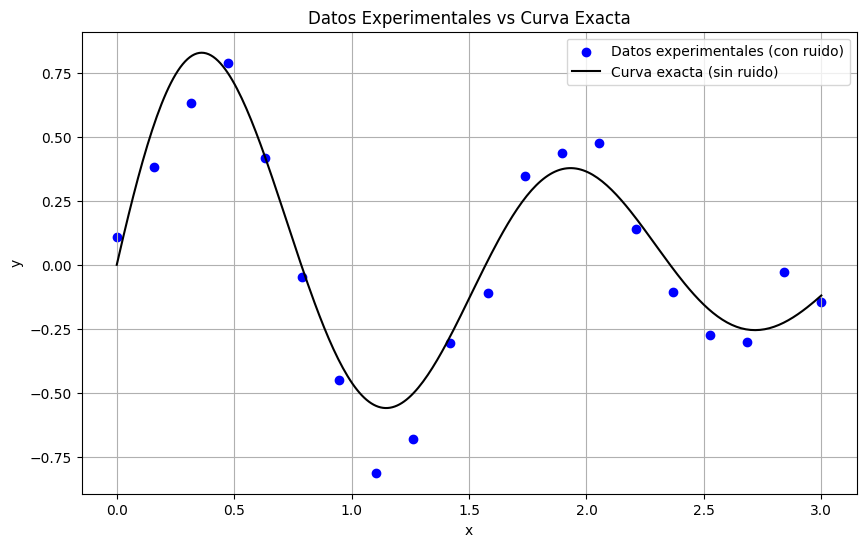

In [7]:
# Interpolación sobre 300 puntos en el mismo rango para la curva exacta
x_exact_300 = np.linspace(0, 3, 300)
y_exact_300 = f(x_exact_300, w_exact)

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Datos experimentales (con ruido) usando puntos
plt.scatter(x_exact, y_noisy, color="blue", label="Datos experimentales (con ruido)", marker="o")

# Curva exacta (sin ruido)
plt.plot(x_exact_300, y_exact_300, color="black", label="Curva exacta (sin ruido)")

# Etiquetas y leyenda
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos Experimentales vs Curva Exacta")
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 4)

El ajuste de un modelo por cuadrados mínimos, consiste en encontrar el vector de parámetros que minimiza la suma de los cuadrados de las diferencias entre los datos y las predicciones del modelo.
Más precisamente, consiste en minimizar

$$
E(w) = \sum_i (f(x_i,w)-y_i)^2
$$

con respecto a $w$.

**1)** Minimice $E(w)$ utilizando el algoritmo del descenso por el gradiente.
Implemente el algoritmo utilizando `pytorch`. Saque ventaja de la capacidad de `pytorch` de calcular gradientes de manera automática. Utilice un learning rate $\eta=0.001$ y como valores iniciales de $w$, los originales, pero levemente perturbados con un números aleatorios obtenidos de una distribución normal de media $1$ y desviación estandard $0.25$.

**2)** Grafique, utilizando los mismos 300 puntos de antes, la curva ajustada por el algoritmo anterior.

In [8]:
# 4.1)

# Learning rate
lr = 0.001 
# Número de épocas
n_epochs = 1000
np.random.seed(0)
w_ini = [p * (1 + 0.25 * np.random.normal()) for p in w_exact]

w_tensor = [torch.tensor([p], requires_grad=True, dtype=torch.float64) for p in w_ini]
y_tensor = torch.tensor(y_noisy)
x_tensor = torch.tensor(x_exact)

for epoch in range(n_epochs):

    # Calculamos las predicciones de nuestro modelo, el error y la funcion de pérdida.
    f_torch = torch.exp(-w_tensor[0]*x_tensor)*torch.sin(w_tensor[1] *x_tensor)
    loss = ((f_torch - y_tensor)**2).sum()

    # Calculamos los gradientes
    loss.backward()

    # Actualizamos los parametros con los gradientes, desactivamos el cálculo de gradientes automáticos que realiza PyTorch (no queremos que se acumulen)
    with torch.no_grad():
        for p in w_tensor:
            p -= lr * p.grad

    # Reiniciamos los gradientes a cero, esto es para que no se acumulen en cada iteración de entrenamiento (PyTorch los acumula por defecto),
    # si se acumulan, los gradientes se sumarán en cada iteración y esto ocasionará que el modelo no aprenda correctamente.
    for p in w_tensor:
        p.grad.zero_()

    # Mostramos el error cada 100 épocas
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")


# Mostramos los valores finales de los parámetros
print(f"w_exact: {w_exact}")
print(f"w_ini: {w_ini}")
print(f"w_tensor: {[p.item() for p in w_tensor]}")




Epoch 0: Loss 0.9825412007194765
Epoch 200: Loss 0.32578227909921686
Epoch 400: Loss 0.24783271753404895
Epoch 600: Loss 0.2464299639867866
Epoch 800: Loss 0.24641713269053836
w_exact: (0.5, 4)
w_ini: [0.720506543245958, 4.400157208367223]
w_tensor: [0.4083665346250645, 4.040359364203113]


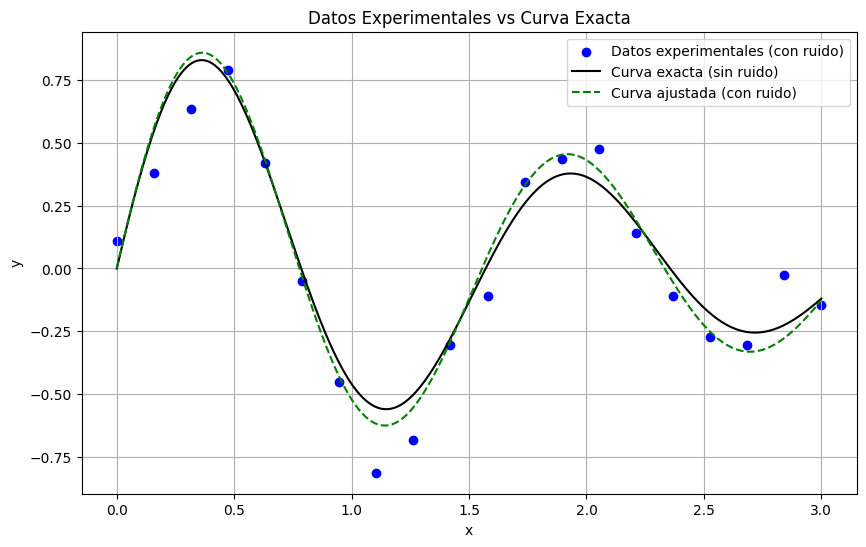

In [9]:
w_fixed = [p.item() for p in w_tensor]
y_fixed_20 = np.exp(-w_fixed[0]*x_exact)*np.sin(w_fixed[1]*x_exact)
y_fixed_300 = np.exp(-w_fixed[0]*x_exact_300)*np.sin(w_fixed[1]*x_exact_300)

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Datos experimentales (con ruido) usando puntos
plt.scatter(x_exact, y_noisy, color="blue", label="Datos experimentales (con ruido)", marker="o")

# Curva exacta (sin ruido)
plt.plot(x_exact_300, y_exact_300, color="black", label="Curva exacta (sin ruido)")
plt.plot(x_exact_300, y_fixed_300, color="green", label="Curva ajustada (con ruido)", linestyle="--")

# Etiquetas y leyenda
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos Experimentales vs Curva Exacta")
plt.legend()
plt.grid(True)
plt.show()


## Ejercicio 5)

**1)** Repita el ejercicio anterior, pero ahora ajustando el modelo

$$
f(x,w) = \exp(-w_0x+w_2)\sin(w_1x+w_3)
$$

i.e. un modelo con dos parámetros ajustables extra.


In [31]:
# 5.1)

# Learning rate
lr = 0.001 
# Número de épocas
n_epochs = 3000

np.random.seed(0)
w_ini2 = [p * (1 + 0.25 * np.random.normal()) for p in w_exact]

w_tensor2 = [torch.tensor([p], requires_grad=True, dtype=torch.float64) for p in w_ini + [0.1, 0.1]]
y_tensor2 = torch.tensor(y_noisy)
x_tensor2 = torch.tensor(x_exact)

for epoch in range(n_epochs):

    # Calculamos las predicciones de nuestro modelo, el error y la funcion de pérdida.
    f_torch = torch.exp(-w_tensor2[0]*x_tensor + w_tensor2[2])*torch.sin(w_tensor2[1] *x_tensor + w_tensor2[3])
    loss = ((f_torch - y_tensor)**2).sum()

    # Calculamos los gradientes
    loss.backward()

    # Actualizamos los parametros con los gradientes, desactivamos el cálculo de gradientes automáticos que realiza PyTorch (no queremos que se acumulen)
    with torch.no_grad():
        for p in w_tensor2:
            p -= lr * p.grad

    # Reiniciamos los gradientes a cero, esto es para que no se acumulen en cada iteración de entrenamiento (PyTorch los acumula por defecto),
    # si se acumulan, los gradientes se sumarán en cada iteración y esto ocasionará que el modelo no aprenda correctamente.
    for p in w_tensor2:
        p.grad.zero_()

    # Mostramos el error cada 100 épocas
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")


# Mostramos los valores finales de los parámetros
print(f"w_exact: {w_exact}")
print(f"w_ini: {w_ini2}")
print(f"w_tensor2: {[p.item() for p in w_tensor2]}")




Epoch 0: Loss 1.1771920336633
Epoch 200: Loss 0.32615303716599436
Epoch 400: Loss 0.2699248574831526
Epoch 600: Loss 0.25048892682741064
Epoch 800: Loss 0.24167913354110962
Epoch 1000: Loss 0.2376058682840796
Epoch 1200: Loss 0.2356970702762744
Epoch 1400: Loss 0.23479348269885147
Epoch 1600: Loss 0.2343625777609765
Epoch 1800: Loss 0.2341560002494733
Epoch 2000: Loss 0.23405659554747338
Epoch 2200: Loss 0.23400863621276363
Epoch 2400: Loss 0.23398545475108845
Epoch 2600: Loss 0.2339742353553726
Epoch 2800: Loss 0.2339688004724243
w_exact: (0.5, 4)
w_ini: [0.720506543245958, 4.400157208367223]
w_tensor2: [0.3585848230768442, 4.067694232824657, -0.080600950989489, -0.03612980201020862]


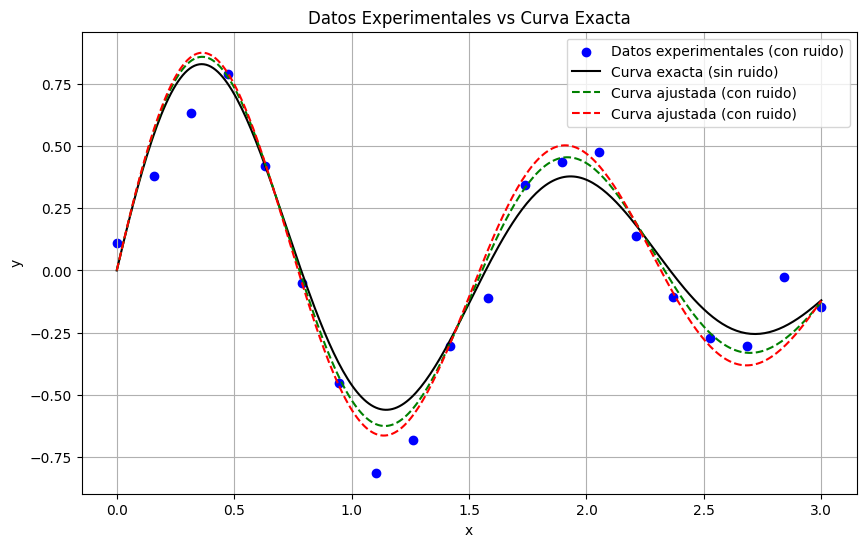

In [32]:
w_fixed2 = [p.item() for p in w_tensor2]
y_fixed2_20 = np.exp(-w_fixed2[0]*x_exact)*np.sin(w_fixed2[1]*x_exact)
y_fixed2_300 = np.exp(-w_fixed2[0]*x_exact_300)*np.sin(w_fixed2[1]*x_exact_300)

# Crear la gráfica
plt.figure(figsize=(10, 6))

# Datos experimentales (con ruido) usando puntos
plt.scatter(x_exact, y_noisy, color="blue", label="Datos experimentales (con ruido)", marker="o")

# Curva exacta (sin ruido)
plt.plot(x_exact_300, y_exact_300, color="black", label="Curva exacta (sin ruido)")
plt.plot(x_exact_300, y_fixed_300, color="green", label="Curva ajustada (con ruido)", linestyle="--")
plt.plot(x_exact_300, y_fixed2_300, color="red", label="Curva ajustada (con ruido)", linestyle="--")

# Etiquetas y leyenda
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos Experimentales vs Curva Exacta")
plt.legend()
plt.grid(True)
plt.show()



**2)** Calcule el error cuadratico medio de ambos modelos, sobre los 30 puntos de entrenamiento y sobre los 300 puntos del la curva exacta.

In [33]:
# 5.2)

ecm1_20 = ((y_fixed_20 - y_noisy)**2).sum()
ecm2_20 = ((y_fixed2_20 - y_noisy)**2).sum()

ecm1_300 = ((y_fixed_300 - y_exact_300)**2).sum()
ecm2_300 = ((y_fixed2_300 - y_exact_300)**2).sum()


print(f"ECM1 20: {ecm1_20}")
print(f"ECM2 20: {ecm2_20}")
print(f"ECM1 300: {ecm1_300}")
print(f"ECM2 300: {ecm2_300}")

ECM1 20: 0.24641702242391725
ECM2 20: 0.2643585447579116
ECM1 300: 0.6914818052339299
ECM2 300: 1.8524230798441823
